# The BART model

In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np
import bayesflow as bf

INFO:bayesflow:Using backend 'jax'

### Simulator

In [2]:
def prior():
    return dict(
        gamma = np.random.exponential(scale=1),
        beta = np.random.exponential(scale=1)
    )

def likelihood(gamma, beta, n_trials=90, p=0.15):
    omega = - gamma / np.log1p(-p)

    d = np.zeros(n_trials)

    for i in range(n_trials):
        n_pumps = 0

        while True: 
            theta = 1 / (1 + np.exp(beta * (n_pumps + 1 - omega)))

            pump = np.random.binomial(n=1, p=theta)
            if not pump:
                break

            n_pumps += 1

            bust = np.random.binomial(n=1, p=p)
            if bust:
                break
        
        d[i] = n_pumps
    
    return dict(d = d)

simulator = bf.make_simulator([prior, likelihood])

### Approximator

We will use the `BasicWorkflow` to train an approximator that consists
of an affine coupling flow inference network and a deep set summary
network. The task is to infer the posterior distrobutions of $\gamma$
and $\delta$, given the observed decisions to pump the baloon ($d$) in
each of the 90 trials.

In [3]:
adapter = (bf.Adapter()
    .as_set("d")
    .constrain(["gamma", "beta"], lower=0)
    .standardize(["gamma", "beta"])
    .concatenate(["gamma", "beta"], into="inference_variables")
    .rename("d", "summary_variables")
)

In [4]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow(),
    summary_network=bf.networks.DeepSet(),
    initial_learning_rate=1e-3
)

### Training

In [5]:
history=workflow.fit_online(epochs=100, num_batches_per_epoch=200, batch_size=128)

### Validation

In [6]:
test_data=simulator.sample(1000)

In [7]:
figs=workflow.plot_default_diagnostics(test_data=test_data, num_samples=500)

### Inference

Here we will fit the model to two participants (George and Bill), each
under three different conditions (Sober, Tipsy, Drunk) (Lee &
Wagenmakers, 2013).

In [8]:
inference_data = np.loadtxt(os.path.join("data", "george-bill.txt"), delimiter=" ")
inference_data = inference_data.reshape((6, 90, 1))

inference_data = dict(d=inference_data)

In [9]:
posterior_samples = workflow.sample(num_samples=2000, conditions=inference_data)

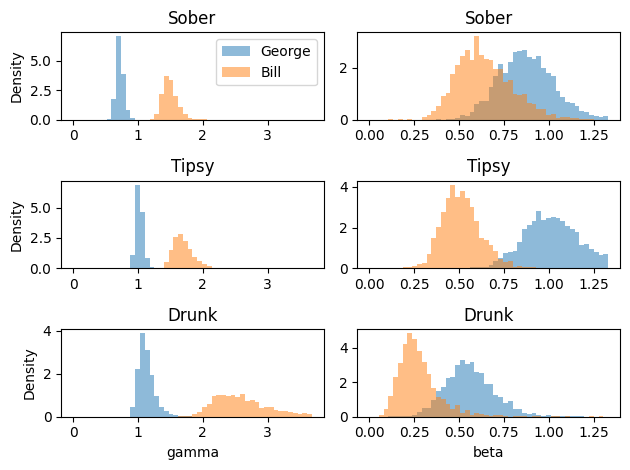

In [10]:
fig, axes = plt.subplots(3, 2)

bins = {par: np.linspace(0, np.quantile(samples, 0.99), 51) for par, samples in posterior_samples.items()}

for i, cond in enumerate(["Sober", "Tipsy", "Drunk"]):
    for j, (par, samples) in enumerate(posterior_samples.items()):
        axes[i,j].hist(samples[i].flatten(), alpha=0.5, bins=bins[par], density=True) 
        axes[i,j].hist(samples[i+3].flatten(), alpha=0.5, bins=bins[par], density=True) 
        axes[i,j].set_title(cond)
        
        if j == 0:
            axes[i,j].set_ylabel("Density")

            if i == 0:
                axes[i,j].legend(["George", "Bill"])

        if cond == "Drunk":
            axes[i,j].set_xlabel(par)

fig.tight_layout()


Lee, M. D., & Wagenmakers, E.-J. (2013). *Bayesian Cognitive Modeling: A
Practical Course*. Cambridge University Press.